# Split the data

Prepare the data by encoding the non-numeric variables and applying a train-test split:

In [299]:
import pandas as pd
from sklearn.model_selection import \
	train_test_split
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('data/life_expectancy.csv')

label_encoder = LabelEncoder()
data['Country'] = (
	label_encoder.fit_transform(data['Country'])
)

data_train, data_test = train_test_split(
	data,
	test_size=0.2,
	random_state=42
)

# Single variable linear regression model

### Find a candidate variable

Identify the variables with the strongest relationship with the target variable `Life Expectancy at Birth, both sexes (years)` using the Pearson correlation coefficient:

In [300]:
target_variable = \
	'Life Expectancy at Birth, both sexes (years)'

correlations = (
	data_train
	.corr(method='pearson')[target_variable]
	.abs().sort_values(ascending=False)
)
correlations

Life Expectancy at Birth, both sexes (years)                                       1.000000
Human Development Index (value)                                                    0.918341
Crude Birth Rate (births per 1,000 population)                                     0.864138
Coefficient of human inequality                                                    0.849600
Total Fertility Rate (live births per woman)                                       0.838654
Expected Years of Schooling, female (years)                                        0.814086
Adolescent Birth Rate (births per 1,000 women ages 15-19)                          0.799662
Expected Years of Schooling (years)                                                0.799646
Median Age, as of 1 July (years)                                                   0.797353
Expected Years of Schooling, male (years)                                          0.778834
Net Reproduction Rate (surviving daughters per woman)                           

In [301]:
candidate_variable = correlations.index[1]
print(
	f'Candidate variable: "{candidate_variable}"'
)

Candidate variable: "Human Development Index (value)"


### Constructing the model

Construct a linear regression model using the variable with the strongest relationship with the target variable:

In [302]:
from sklearn.linear_model import LinearRegression

X_train = data_train[[candidate_variable]]
y_train = data_train[target_variable]

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Computing the metrics of the model:

In [303]:
r_squared = model.score(X_train, y_train)
coefficients = model.coef_
intercept = model.intercept_

print(f'R-squared: {r_squared}')
print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

R-squared: 0.8433493090941087
Coefficients: [51.42339338]
Intercept: 34.60462419807184


Plot the linear regression model:

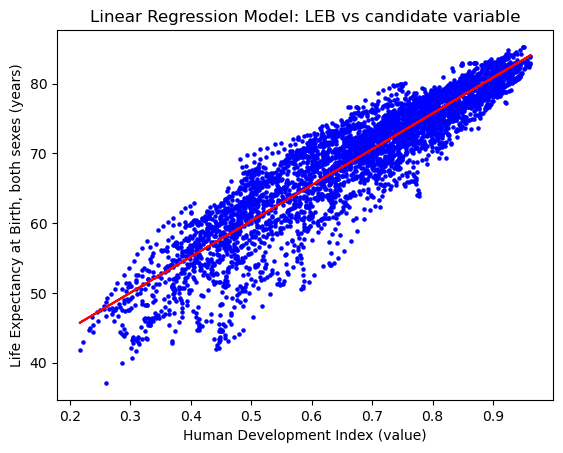

In [304]:
import matplotlib.pyplot as plt

plt.scatter(X_train, y_train, color='blue', s=5)
plt.plot(
	X_train, model.predict(X_train),
	color='red'
)
plt.title(
	'Linear Regression Model: LEB vs candidate variable'
)
plt.xlabel(candidate_variable)
plt.ylabel(target_variable)

plt.savefig(
	"scatter_plot_single_linear_model.png"
)

### Predict the test set

Predict the target variable using the test data and computing the **mean squared error** and **correlation coefficient**:

In [305]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

X_test = data_test[[candidate_variable]]
y_test = data_test[target_variable]
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
correlation, _ = pearsonr(y_pred, y_test)

print(f'Mean squared error: {mse}')
print(f'Correlation: {correlation}')


Mean squared error: 12.519251362188522
Correlation: 0.920387001630666


# Non-linear relationship

### Find a second candidate

Identify the variables with the strongest relationship with the target variable `Life Expectancy at Birth, both sexes (years)` using the Spearman correlation coefficient:

In [306]:
data_train = data_train.drop(
	columns=[candidate_variable]
)

correlations = (
	data_train
	.corr(method='spearman')[target_variable]
	.abs().sort_values(ascending=False)
)
correlations

Life Expectancy at Birth, both sexes (years)                                       1.000000
Gross National Income Per Capita (2017 PPP$)                                       0.864828
Median Age, as of 1 July (years)                                                   0.863765
Crude Birth Rate (births per 1,000 population)                                     0.848640
Expected Years of Schooling, female (years)                                        0.834567
Coefficient of human inequality                                                    0.828904
Expected Years of Schooling (years)                                                0.819759
Total Fertility Rate (live births per woman)                                       0.816936
Adolescent Birth Rate (births per 1,000 women ages 15-19)                          0.811920
Expected Years of Schooling, male (years)                                          0.806563
Material footprint per capita (tonnes)                                          

After choosing `Gross National Income Per Capita (2017 PPP$)` as candidate, we plot the relationship:

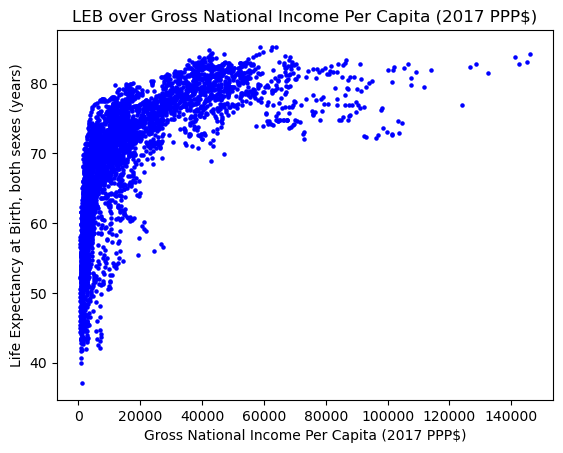

In [307]:
second_candidate_variables = 'Gross National Income Per Capita (2017 PPP$)'

plt.scatter(
	data_train[second_candidate_variables],
	data_train[target_variable],
	color='blue', s=5
)
plt.title(
	f'LEB over {second_candidate_variables}'
)
plt.xlabel(second_candidate_variables)
plt.ylabel(target_variable)

plt.savefig(
	"scatter_plot_nonlinear_mono_model.png"
)

The relationship appears to be logarithmic.

### Construct the model on the transformed scale

Applying the logarithmic transformation to the candidate variable:

In [308]:
import numpy as np

X_train = data_train[[second_candidate_variables]]
y_train = data_train[target_variable]

log_X_train = np.log(X_train)

model = LinearRegression()
model.fit(log_X_train, y_train)

LinearRegression()

Computing the metrics of the model:

In [309]:
r_squared = model.score(log_X_train, y_train)
coefficients = model.coef_
intercept = model.intercept_

print(f'R-squared: {r_squared}')
print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

R-squared: 0.6939267719160521
Coefficients: [6.46720934]
Intercept: 9.942320920335249


Plotting the linear regression model:

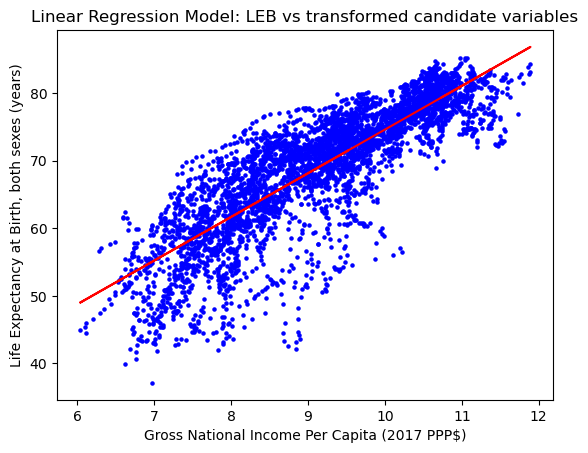

In [310]:
plt.scatter(
	log_X_train, y_train,
	color='blue', s=5
)
plt.plot(
	log_X_train, model.predict(log_X_train),
	color='red'
)
plt.title(
	'Linear Regression Model: LEB vs transformed candidate variables'
)
plt.xlabel(second_candidate_variables)
plt.ylabel(target_variable)

plt.savefig(
	"scatter_plot_nonlinear_mono_transformed_model.png"
)

### Comparing the transformation
Computing the correlation coefficient before and after the transformation

In [311]:
original_correlation, _ = (
	pearsonr(X_train.values.flatten(), y_train)
)
transformed_correlation, _ = (
	pearsonr(log_X_train.values.flatten(), y_train)
)

print(f'''
Original correlation:    {original_correlation}
Transformed correlation: {transformed_correlation}
''')


Original correlation:    0.6514708331957302
Transformed correlation: 0.833022671909986



# Multiple linear regression model

### Research the candidates

We believe the Pearson coefficient is an effective way to select variables as it indicates how strong the relationship between a variable and LEB is. 

We consider the top 8 variables with Pearson coefficients of the highest magnitude. These are:

- Crude Birth Rate (births per 1,000 population)
- Coefficient of human inequality
- Total Fertility Rate (live births per woman)
- Expected Years of Schooling, female (years)
- Adolescent Birth Rate (births per 1,000 women ages 15-19)
- Expected Years of Schooling (years)
- Median Age, as of 1 July (years)
- Expected Years of Schooling, male (years)

However, `Expected Years of Schooling (years)` is able to capture the information from `Expected Years of Schooling. female (years)` and `Expected Years of Schooling. male (years)`  

This leaves us with 6 remaining variables to consider further and test.

In [313]:
candidates = [
	'Crude Birth Rate (births per 1,000 population)',
	'Coefficient of human inequality',
	'Total Fertility Rate (live births per woman)',
	'Adolescent Birth Rate (births per 1,000 women ages 15-19)',
	'Expected Years of Schooling (years)',
	'Median Age, as of 1 July (years)',
	'Net Reproduction Rate (surviving daughters per woman)'
]

### Construct the model

Construct a linear regression model using the found candidates with the target variable:

In [317]:
data_train = data_train[
	candidates + [target_variable]
	].dropna()
data_test = data_test[
	candidates + [target_variable]
	].dropna()

X_train = data_train[candidates]
y_train = data_train[target_variable]

model = LinearRegression()
model.fit(X_train, y_train)

r_squared = model.score(X_train, y_train)
coefficients = model.coef_
intercept = model.intercept_

print(f'R-squared: {r_squared}')
print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

R-squared: 0.8673778882429013
Coefficients: [-7.88494739e-01 -1.12419551e-01 -8.60456539e+00 -1.51153253e-02
  3.21929313e-01  8.46505738e-02  2.90244232e+01]
Intercept: 71.76617234571023


### Predict the test set

Predict the target variable using the test data and computing the **mean squared error** and **correlation coefficient**:

In [315]:
X_test = data_test[candidates]
y_test = data_test[target_variable]
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
correlation, _ = pearsonr(y_pred, y_test)

print(f'Mean squared error: {mse}')
print(f'Correlation: {correlation}')

Mean squared error: 8.879386934439953
Correlation: 0.9363399256423098
